## Topic Identification using Latent Dirichlet Allocation Model

The objective of this document is to identify the various topics avaialable. We are going through following steps:

    1.Read the data from the file
    2.Filter the data to get the low rated reviews only
    3.Identify the non english reviews and remove the corresponding reviews as we can work only with English reviews
    3.Next we have cleared any special characters and number from the review text
    4.changed the casing of the text to lower case to ensure that we get same format for lemmatised text
    5.We have used english stopwords from nltk.corpus library to remove the stopwords fro review text
    7.We have taken the cleaned text from above to identify the topics.

To identify the topics we have used an Latent Dirichlet allocation algorithm. We have performed following steps:

    1.We assume that each review text is one document.
    2.We have calculated the bigrams and corresponding polarity of the bigrams from the cleaned text.
    3.We have calculated the polarity of each document to identify the negative bigrams using the textblob library.
    4.Filtered out all the positive and the neutral bigrams to ensure that we are working with only negative bigrams.
    5.Used the CountVectorizer for all the reviews to create the sparse matrix.
    6.Used sklearn.LatentDirichletAllocation model with gridsearch with number of topics ranging from 3 to 10. 
    7. With maximumloglikelyhood, it has been identified that the best number of topics is 3.
    8. Validated the outcome of the LDA model with manual labelling of 110 reviews. The accuracy was found to 68%.
    9. Labelled the reviews with the model as food, service and others.
    10. Persisted the data for UI presentation


In [1]:
import pandas as pd
import numpy as np

#To detect the languages
from langdetect import detect

#for distributed task, to make the processing faster
import dask.dataframe as dd
from dask.multiprocessing import get

#importing regular expressions to handle the text data
import re

#Text Processing libraries
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from time import time

#Following libraries are used for topic identification
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

# Plotting tools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Plotting tools for the LDA data
import pyLDAvis
import pyLDAvis.sklearn
%matplotlib inline

In [2]:
#Read the data
reviewsP1_R_High = pd.read_csv("Bigrams/data/AZ_restaurant_low_high_review_final.csv", sep="\t")

In [3]:
reviewsP1_R_High.shape

(276327, 12)

In [4]:
reviewsP1_R_High.head(5)

,User_id,Business_id,Name,Address,City,State,Postal_code,Review_count,Restaurant_ratings,RestaurantsPriceRange2,Review_ratings,Review_text
0,Ck73f1qtZbu68F_vjzsBrQ,rDMptJYWtnMhpQu_rRXHng,McDonald's,719 E Thunderbird Rd,Phoenix,AZ,85022.0,10.0,1.0,1.0,1.0,The speed of delivery of my food order was ter...
1,F95NFEFwuwA__SIRt9IJNA,rDMptJYWtnMhpQu_rRXHng,McDonald's,719 E Thunderbird Rd,Phoenix,AZ,85022.0,10.0,1.0,1.0,1.0,I stopped by for a double quarter pounder with...
2,2gWCW1oEuyhaxrlTTghvtQ,rDMptJYWtnMhpQu_rRXHng,McDonald's,719 E Thunderbird Rd,Phoenix,AZ,85022.0,10.0,1.0,1.0,1.0,I was told tonight at 8:30 pm that they were n...
3,yKyfDC9EPHvSuBXPCP-EmQ,rDMptJYWtnMhpQu_rRXHng,McDonald's,719 E Thunderbird Rd,Phoenix,AZ,85022.0,10.0,1.0,1.0,1.0,Cashier was disgusting and unsanitary. Picking...
4,wxu6RAQqre73_id5lALttA,rDMptJYWtnMhpQu_rRXHng,McDonald's,719 E Thunderbird Rd,Phoenix,AZ,85022.0,10.0,1.0,1.0,1.0,Don't waste your money! Terrible service. The...


### Filtering data to take only low rated reviews

In [5]:
Lowrated = reviewsP1_R_High[reviewsP1_R_High['Review_ratings'] < 3]

In [6]:
## For LDA topic identification and suggestion to businesses we need only review text and business id

In [7]:
ReviewData = Lowrated[['Business_id','Review_text']]


In [8]:
ReviewData.head()

,Business_id,Review_text
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was ter...
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were n...
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking...
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. The...


### Filtering out the non english reviews to ensure that we are working only with English Data

In [9]:
#Non Dask implementation
def filterNonEnglishReviews(df):
    df["language"]=df["Text"].apply(detect)
    df=df[df["language"] == 'en']
    df = df.drop("language" , axis=1)
    return df

In [10]:
def removeSpecialCharsandGetLanguage(text):
    #print(text)
    if(pd.isnull(text)):
        text=""    
    lettersonly =  re.sub("[^a-zA-Z]", " ", text)
    #print(lettersonly)
    # 豬肋排好吃不油膩, 加點醋醬風味更佳。\r\n炭烤半雞也不賴。小菜不錯, 服務也很貼心, 吃...
    #Above line is giving error with language detection
    try:
        lang=detect(lettersonly)
    except:
        lang='notknown'
        pass
    
    return lang

In [11]:
#Testing if above is working as expected
removeSpecialCharsandGetLanguage("豬肋排好吃不油膩, 加點醋醬風味更佳。\r\n炭烤半雞也不賴。小菜不錯, 服務也很貼心, 吃...")

'notknown'

In [12]:
#Implementing the language detection using dask libraries as to improve performance
def getLanguageDask(df):
    ddata = dd.from_pandas(df, npartitions=30)
    lang = ddata.map_partitions(lambda df: df.apply((lambda row: removeSpecialCharsandGetLanguage(row["Review_text"])), axis=1)).compute(get=get)
    return lang

In [13]:
#Testing if above is working as expected
testdf = ReviewData.head(5).copy(deep=True)

testdf.set_value(0,"Review_text"," 豬肋排好吃不油膩, 加點醋醬風味更佳。\r\n炭烤半雞也不賴。小菜不錯, 服務也很貼心")
lang = getLanguageDask(testdf)
testdf["lang"] = lang
testdf.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\dask\base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


,Business_id,Review_text,lang
0,rDMptJYWtnMhpQu_rRXHng,"豬肋排好吃不油膩, 加點醋醬風味更佳。\r\n炭烤半雞也不賴。小菜不錯, 服務也很貼心",notknown
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...,en
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were n...,en
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking...,en
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. The...,en


In [14]:
#Adding Language column
lang = getLanguageDask(ReviewData)
ReviewData["lang"] = lang


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#checking the dataframes
ReviewData.head(2)

,Business_id,Review_text,lang
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was ter...,en
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...,en


In [16]:
def removeNonEnglishReviews(df):
    totalreviewscount = df.shape[0]
    print("# of records before filtering for non english: %d"%(totalreviewscount))

    df= df[df["lang"] == "en"] 
    cntAfterFilter = df.shape[0]
    cntFiltered = totalreviewscount - cntAfterFilter
    print("# of non english records filtered out: %d"%(cntFiltered))
    return df

In [17]:
ReviewData = removeNonEnglishReviews(ReviewData)

# of records before filtering for non english: 16767
# of non english records filtered out: 8


In [18]:
ReviewData.head()

,Business_id,Review_text,lang
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was ter...,en
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...,en
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were n...,en
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking...,en
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. The...,en


In [19]:
#Saving intermediate results for future processing, index false helps to remove the unnamed colmn created
ReviewData.to_csv("ReviewData_eng.csv", index=False)

In [20]:
#Loading from intermediate csvs
ReviewData_eng = pd.read_csv("ReviewData_eng.csv")


In [21]:
ReviewData_eng.head()

,Business_id,Review_text,lang
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was ter...,en
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...,en
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were n...,en
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking...,en
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. The...,en


### Review text preprocessing and cleaning

In [22]:
#Define the stop words list
stop =  set(stopwords.words("english"))
    
#This method is performing following steps:
'''
1. Removing any html tokens
2. removing any special charatcters
3. removing any numeric character
4.removing extra spaces
5. filtering the stop words
6. bringing all the words to lower casing
'''
def cleanText(reviewText):
    htmlremoved = re.sub(re.compile('<.*?>'), '', str(reviewText)) 
    filtered_review_token =  [word for word in htmlremoved.split() if word.lower() not in stop]
    joined = " ".join(filtered_review_token)
    lettersonly =  re.sub("[^a-zA-Z]", " ", joined)
    spaceremoved = re.sub(' +',' ',str(lettersonly)) #re.sub('  ', ' ', str(lettersonly))
    lower = spaceremoved.lower()
    return lower

In [23]:
#This was fast..did not require the Dask implementation
ReviewData_eng["cleantext"] = ReviewData_eng.Review_text.apply(cleanText)

In [24]:
ReviewData_eng.head()

,Business_id,Review_text,lang,cleantext
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was ter...,en,speed delivery food order terrible took minute...
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...,en,stopped double quarter pounder cheese no pickl...
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were n...,en,told tonight pm serving breakfast excuse me me...
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking...,en,cashier disgusting unsanitary picking nail s l...
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. The...,en,waste money terrible service idea good custome...


In [25]:
ReviewData_eng["tokens"] =ReviewData_eng.cleantext.str.split(" ")

### Create bigrams and identify negativev text

In [26]:
#This function is created to create Bigrams
#This is taking 2 consecutive words as they appear in the document and create a bigram

def calculateBigrams(tokens):
    bigrams = [(tokens[i],tokens[i+1]) for i in range(0,len(tokens)-1)]
    return bigrams

In [27]:
ReviewData_eng["bigrams"] =ReviewData_eng.tokens.apply(calculateBigrams)

In [28]:
ReviewData_eng.head(5)

,Business_id,Review_text,lang,cleantext,tokens,bigrams
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was ter...,en,speed delivery food order terrible took minute...,"[speed, delivery, food, order, terrible, took,...","[(speed, delivery), (delivery, food), (food, o..."
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...,en,stopped double quarter pounder cheese no pickl...,"[stopped, double, quarter, pounder, cheese, no...","[(stopped, double), (double, quarter), (quarte..."
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were n...,en,told tonight pm serving breakfast excuse me me...,"[told, tonight, pm, serving, breakfast, excuse...","[(told, tonight), (tonight, pm), (pm, serving)..."
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking...,en,cashier disgusting unsanitary picking nail s l...,"[cashier, disgusting, unsanitary, picking, nai...","[(cashier, disgusting), (disgusting, unsanitar..."
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. The...,en,waste money terrible service idea good custome...,"[waste, money, terrible, service, idea, good, ...","[(waste, money), (money, terrible), (terrible,..."


In [29]:
'''
This function accepts the cleaned text,
Identifies bigrams,
calculates polarity using textblob
filter out the positive and neautral bigrams
create a final bag of words
'''

def getPolarity(cleantext):
    tokens = cleantext.split(" ")
    bigram = calculateBigrams(tokens)
    negative_bigrams = []
    for x,y in bigram:
        #print(x +" "+y)
        text=x +" "+y
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity
        #print(polarity)
        if polarity < 0:
            negative_bigrams.append(text)
    finaltext=" ".join(negative_bigrams)
    finaltext
    return finaltext

In [30]:
#Distributed library implementation for the getpolarity function
def getNegativeDask(df):
    ddata1 = dd.from_pandas(df, npartitions=30)
    txt = ddata1.map_partitions(lambda df: df.apply((lambda row: getPolarity(row["cleantext"])), axis=1)).compute(get=get)
    return txt

In [31]:
#Get the negative text
ReviewData_eng["negativetext"]=getNegativeDask(ReviewData_eng)


In [32]:
ReviewData_eng.to_csv("ReviewData_eng_negative.csv",index = False)

In [33]:
ReviewData_eng.head()

,Business_id,Review_text,lang,cleantext,tokens,bigrams,negativetext
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was ter...,en,speed delivery food order terrible took minute...,"[speed, delivery, food, order, terrible, took,...","[(speed, delivery), (delivery, food), (food, o...",order terrible terrible took institution disap...
1,rDMptJYWtnMhpQu_rRXHng,I stopped by for a double quarter pounder with...,en,stopped double quarter pounder cheese no pickl...,"[stopped, double, quarter, pounder, cheese, no...","[(stopped, double), (double, quarter), (quarte...",bun hard hard crusty shades hard hard tips tip...
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were n...,en,told tonight pm serving breakfast excuse me me...,"[told, tonight, pm, serving, breakfast, excuse...","[(told, tonight), (tonight, pm), (pm, serving)...",breakfast excuse excuse me location serious se...
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking...,en,cashier disgusting unsanitary picking nail s l...,"[cashier, disgusting, unsanitary, picking, nai...","[(cashier, disgusting), (disgusting, unsanitar...",cashier disgusting disgusting unsanitary
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. The...,en,waste money terrible service idea good custome...,"[waste, money, terrible, service, idea, good, ...","[(waste, money), (money, terrible), (terrible,...",waste money money terrible terrible service li...


In [34]:
#Taking only negative review text data for further processing
negativedata = ReviewData_eng["negativetext"]

### Create the review-word matrix

In [35]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(negativedata)

### GridSearch to find the best LDA model

In [36]:
# Define Search Param
search_params = {'n_topics': [3,5,7,9,10]}

# Init the Model
lda = LatentDirichletAllocation(random_state = 22, max_iter=10)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=22, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_topics': [3, 5, 7, 9, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

## See the best topic model and its parameters

In [37]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'n_topics': 3}
Best Log Likelihood Score:  -409867.1266978732
Model Perplexity:  1113.6769077820154


##  Compare LDA Model Performance Scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


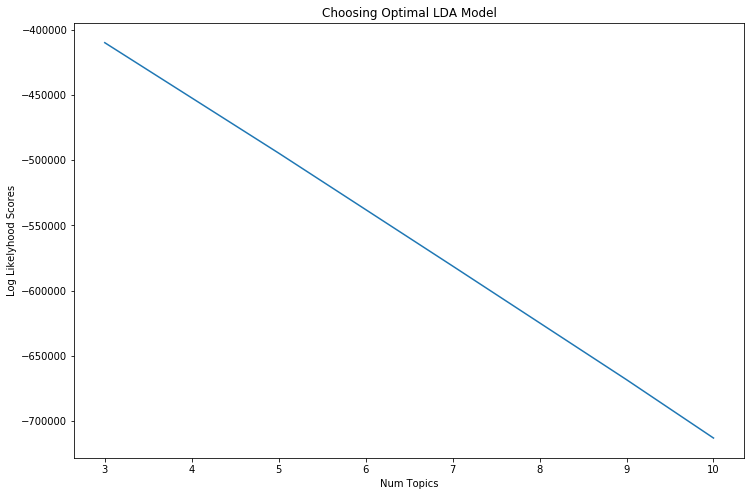

In [38]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [3,5,7,9,10]
log_likelyhoods = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ ]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods)
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.show()

In [39]:
#We want to label the topics starting from 1,2,3 and so on.
#Any document having equal probabilities will be labelled -1
def getLabel(row):
    retval=-1
    max_val = 0
    for i in range(ntopics):
        if(row[i]>max_val):
            max_val = row[i]
            retval = i
    #Checking for equal probabilities, return -1 in that case
    isequal = -1
    
    for i in range(ntopics-1):
        if(row[i] != row[i+1]):
            isequal = 0
            break
    
    if isequal == 0:
        return retval+1
    else:
        return -1

In [40]:
# Create review - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i+1) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(ReviewData_eng))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)#, index=docnames)

# Get dominant topic for each document
#dominant_topic = np.argmax(df_document_topic.values, axis=1)

ntopics = best_lda_model.n_topics
predict_df = pd.DataFrame( lda_output)
predict_df["Label"] = predict_df.apply(getLabel, axis=1)


labels = predict_df["Label"]
df_document_topic['dominant_topic'] = labels

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic1,Topic2,Topic3,dominant_topic
0,0.05,0.59,0.36,2
1,0.93,0.03,0.03,1
2,0.03,0.03,0.93,3
3,0.07,0.07,0.86,3
4,0.03,0.37,0.6,3
5,0.33,0.33,0.33,-1
6,0.05,0.9,0.05,2
7,0.05,0.64,0.31,2
8,0.83,0.08,0.08,1
9,0.33,0.33,0.33,-1


## Review topics distribution across documents

In [41]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,6010
1,1,4772
2,2,4495
3,-1,1482


## How to see topic keyword

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array

In [42]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,able,absolute,absolutely,absurd,act,acted,acting,actual,actually,add,...,year,years,yelling,yelp,yes,yesterday,young,yuck,zero,zipps
Topic1,2.402008,0.379711,2.242436,0.353287,0.368295,0.644978,0.349958,12.383779,36.839512,17.888867,...,14.591138,18.823129,0.377158,13.216939,22.908268,8.603595,13.985327,15.040750,4.172241,0.388974
Topic2,9.973467,31.732672,118.136514,47.774911,16.604968,23.233050,12.522881,0.352028,25.224417,2.194786,...,0.401471,0.709696,17.194859,2.946997,10.983274,0.396581,14.337873,0.351473,1.318603,0.393496
Topic3,0.387999,51.345665,226.242161,0.379835,0.448597,0.410643,0.350346,0.343782,20.145120,9.959019,...,32.717270,73.426452,0.385787,6.907091,6.684158,6.743024,0.507714,6.462435,20.648861,39.777010


# Get the top 15 keywords each topic

In [44]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 1,chicken,cold,little,hard,dry,disappointed,small,late,worse,bland,closed,food,stale,negative,black
Topic 2,rude,wrong,terrible,slow,service,worst,sorry,awful,game,order,food,extremely,small,missing,sad
Topic 3,bad,long,horrible,worst,half,service,dirty,poor,disgusting,food,time,place,waste,past,sucks


### Implement LDAvis to visualize word distribution in different topics

In [47]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')

#As the visualization is not proper in the notebook, the same has been save to an html to show
pyLDAvis.save_html(panel, 'lda.html')
pyLDAvis.display(panel)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Validate the LDS model with manually labelled data

In [48]:

validationdata = pd.read_csv("LDA3_ValidationData.csv")

In [49]:
validationdata.head()

,Text,Food,Service,Others,TopicScores,ExpectedTopicScores
0,I love chick fil a and was so excited when the...,0,1,0,3,3
1,I've gone here before love the food but the co...,0,1,0,3,3
2,"If there were negative Stars, I would give the...",0,0,1,1,1
3,This is for nocawich express. Absolutely terri...,0,0,1,1,1
4,Sun Devil Dining on Lemon Street has probably ...,0,1,0,3,3


In [50]:
#Steps to be followed:

validationdata.fillna(0, inplace=True)

In [51]:
validationdata.head(5)

,Text,Food,Service,Others,TopicScores,ExpectedTopicScores
0,I love chick fil a and was so excited when the...,0,1,0,3,3
1,I've gone here before love the food but the co...,0,1,0,3,3
2,"If there were negative Stars, I would give the...",0,0,1,1,1
3,This is for nocawich express. Absolutely terri...,0,0,1,1,1
4,Sun Devil Dining on Lemon Street has probably ...,0,1,0,3,3


In [52]:
validationdata[["Food","Service","Others"]] = validationdata[["Food","Service","Others"]].astype(int)


In [54]:
validationdata.head(5)

,Text,Food,Service,Others,TopicScores,ExpectedTopicScores
0,I love chick fil a and was so excited when the...,0,1,0,3,3
1,I've gone here before love the food but the co...,0,1,0,3,3
2,"If there were negative Stars, I would give the...",0,0,1,1,1
3,This is for nocawich express. Absolutely terri...,0,0,1,1,1
4,Sun Devil Dining on Lemon Street has probably ...,0,1,0,3,3


In [55]:
def predictTopic(reviewText):
    cleantext = cleanText(reviewText)
    negativeText = getPolarity(cleantext)
    #print(negativeText)
    textinput = [negativeText]
    vectorisedtext = vectorizer.transform(textinput)
    topic_probability_scores = best_lda_model.transform(vectorisedtext)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    lst = topic_probability_scores[0].tolist()
    #print(lst)
    topic_label = getLabel(lst)
    return topic_label

    

In [56]:
 prob_scores = predictTopic("Just look at the picture.   Bread was old and brittle.  Ruined the sandwich.  Chips were in a tight hallway on the side not visible.  It was a hot mess here today")

In [57]:
prob_scores

1

In [58]:
topic = validationdata.Text.apply(predictTopic)

In [59]:
validationdata["TopicScores"] = topic

In [60]:
validationdata.head(5)

,Text,Food,Service,Others,TopicScores,ExpectedTopicScores
0,I love chick fil a and was so excited when the...,0,1,0,3,3
1,I've gone here before love the food but the co...,0,1,0,3,3
2,"If there were negative Stars, I would give the...",0,0,1,1,1
3,This is for nocawich express. Absolutely terri...,0,0,1,1,1
4,Sun Devil Dining on Lemon Street has probably ...,0,1,0,3,3


In [61]:
#We have seen that the topic label 2 is about food while 3 is about service

def getExpectedScores(food,service,others):
    #print(food)
    if(food == 1):
        return 2
    elif(service == 1):
        return 3
    else:
        return 1
        
    

In [62]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

In [63]:
validationdata["ExpectedTopicScores"]  = validationdata.apply((lambda x: getExpectedScores(x["Food"], x["Service"],x["Others"])), axis = 1)

In [64]:
validationdata.head(10)

,Text,Food,Service,Others,TopicScores,ExpectedTopicScores
0,I love chick fil a and was so excited when they built this location. Unfortunately this has to ...,0,1,0,3,3
1,I've gone here before love the food but the costumer service is totally horrible. I was at the d...,0,1,0,3,3
2,"If there were negative Stars, I would give them out instead of one star. This place is a disgrac...",0,0,1,1,1
3,This is for nocawich express. Absolutely terrible. Had to run through the airport and saw this l...,0,0,1,1,1
4,Sun Devil Dining on Lemon Street has probably been the worst dining experience I have ever had. ...,0,1,0,3,3
5,I agree with previous posts. This Chick-fil-A is not like the others... just stopped there for i...,0,0,1,1,1
6,"I usually wouldn't write a review about fried chicken chain restaurants, but they're ROTD worthy...",0,0,1,1,1
7,"First visit January 2014, 3pm. The store was clean, lots of staff moving around in the kitchen.\...",0,0,1,1,1
8,I usually love Popeye's!! But this location ruined it for me!!!!! They deserve a negative star r...,1,0,0,1,2
9,"The food was fine, the issue is with the soda dispenser. The ice cubes are literally dirty, you ...",0,1,0,3,3


In [65]:
from sklearn.metrics import confusion_matrix
confusion_matrix(validationdata["ExpectedTopicScores"], validationdata["TopicScores"])

array([[26,  3,  2],
       [ 9, 16,  3],
       [ 3, 14, 32]])

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(validationdata["ExpectedTopicScores"], validationdata["TopicScores"])

0.6851851851851852

In [67]:
validationdata.to_csv("validationdata.csv", index =False)

In [68]:
ReviewData_eng

,Business_id,Review_text,lang,cleantext,tokens,bigrams,negativetext
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was terrible. It took 10 minutes from the time of my ord...,en,speed delivery food order terrible took minutes time order order two salads quarter pounder comb...,"[speed, delivery, food, order, terrible, took, minutes, time, order, order, two, salads, quarter...","[(speed, delivery), (delivery, food), (food, order), (order, terrible), (terrible, took), (took,...",order terrible terrible took institution disappointing disappointing avoid
1,rDMptJYWtnMhpQu_rRXHng,"I stopped by for a double quarter pounder with cheese,no pickles no onions, after work at 2 p.m....",en,stopped double quarter pounder cheese no pickles onions work p m bun hard crusty cheese two diff...,"[stopped, double, quarter, pounder, cheese, no, pickles, onions, work, p, m, bun, hard, crusty, ...","[(stopped, double), (double, quarter), (quarter, pounder), (pounder, cheese), (cheese, no), (no,...",bun hard hard crusty shades hard hard tips tips disappointed disappointed got
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were not serving breakfast. Excuse me? Why does their me...,en,told tonight pm serving breakfast excuse me menu say day breakfast able order breakfast items ev...,"[told, tonight, pm, serving, breakfast, excuse, me, menu, say, day, breakfast, able, order, brea...","[(told, tonight), (tonight, pm), (pm, serving), (serving, breakfast), (breakfast, excuse), (excu...",breakfast excuse excuse me location serious serious need managers ridiculous ridiculous left
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking at her nail's. Leaning against the cash register...,en,cashier disgusting unsanitary picking nail s leaning cash register like stoned keep head press b...,"[cashier, disgusting, unsanitary, picking, nail, s, leaning, cash, register, like, stoned, keep,...","[(cashier, disgusting), (disgusting, unsanitary), (unsanitary, picking), (picking, nail), (nail,...",cashier disgusting disgusting unsanitary
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. They have no idea what good customer service is. They...,en,waste money terrible service idea good customer service is can t take order save lives awful laz...,"[waste, money, terrible, service, idea, good, customer, service, is, can, t, take, order, save, ...","[(waste, money), (money, terrible), (terrible, service), (service, idea), (idea, good), (good, c...",waste money money terrible terrible service lives awful awful lazy lazy wait
5,rDMptJYWtnMhpQu_rRXHng,"The quest is over, we just found the slowest Mickey D's drive thru in the western civilized world!",en,quest over found slowest mickey d s drive thru western civilized world,"[quest, over, found, slowest, mickey, d, s, drive, thru, western, civilized, world, ]","[(quest, over), (over, found), (found, slowest), (slowest, mickey), (mickey, d), (d, s), (s, dri...",
6,rDMptJYWtnMhpQu_rRXHng,"Worst McDonald's ever. Unless you speak Spanish don't bother. They Messed up my order, were rude...",en,worst mcdonald s ever unless speak spanish bother messed order rude refused correct it type jerk...,"[worst, mcdonald, s, ever, unless, speak, spanish, bother, messed, order, rude, refused, correct...","[(worst, mcdonald), (mcdonald, s), (s, ever), (ever, unless), (unless, speak), (speak, spanish),...",worst mcdonald order rude rude refused
7,rDMptJYWtnMhpQu_rRXHng,They are horrible !!!! Gave me my Frappe Half full. I payed for a Medium not a small .,en,horrible gave frappe half full payed medium small,"[horrible, gave, frappe, half, full, payed, medium, small, ]","[(horrible, gave), (gave, frappe), (frappe, half), (half, full), (full, payed), (payed, medium),...",horrible gave frappe half medium small small
8,qB15WElGAlI_eGWjn0kT2w,"Very polite, decent customer service. The rice in my burrito was hard and seemed very old.",en,polite decent customer service rice burrito hard 

In [69]:
ReviewData_eng["topicLabel"] = predict_df["Label"]

In [70]:
ReviewData_eng

,Business_id,Review_text,lang,cleantext,tokens,bigrams,negativetext,topicLabel
0,rDMptJYWtnMhpQu_rRXHng,The speed of delivery of my food order was terrible. It took 10 minutes from the time of my ord...,en,speed delivery food order terrible took minutes time order order two salads quarter pounder comb...,"[speed, delivery, food, order, terrible, took, minutes, time, order, order, two, salads, quarter...","[(speed, delivery), (delivery, food), (food, order), (order, terrible), (terrible, took), (took,...",order terrible terrible took institution disappointing disappointing avoid,2
1,rDMptJYWtnMhpQu_rRXHng,"I stopped by for a double quarter pounder with cheese,no pickles no onions, after work at 2 p.m....",en,stopped double quarter pounder cheese no pickles onions work p m bun hard crusty cheese two diff...,"[stopped, double, quarter, pounder, cheese, no, pickles, onions, work, p, m, bun, hard, crusty, ...","[(stopped, double), (double, quarter), (quarter, pounder), (pounder, cheese), (cheese, no), (no,...",bun hard hard crusty shades hard hard tips tips disappointed disappointed got,1
2,rDMptJYWtnMhpQu_rRXHng,I was told tonight at 8:30 pm that they were not serving breakfast. Excuse me? Why does their me...,en,told tonight pm serving breakfast excuse me menu say day breakfast able order breakfast items ev...,"[told, tonight, pm, serving, breakfast, excuse, me, menu, say, day, breakfast, able, order, brea...","[(told, tonight), (tonight, pm), (pm, serving), (serving, breakfast), (breakfast, excuse), (excu...",breakfast excuse excuse me location serious serious need managers ridiculous ridiculous left,3
3,rDMptJYWtnMhpQu_rRXHng,Cashier was disgusting and unsanitary. Picking at her nail's. Leaning against the cash register...,en,cashier disgusting unsanitary picking nail s leaning cash register like stoned keep head press b...,"[cashier, disgusting, unsanitary, picking, nail, s, leaning, cash, register, like, stoned, keep,...","[(cashier, disgusting), (disgusting, unsanitary), (unsanitary, picking), (picking, nail), (nail,...",cashier disgusting disgusting unsanitary,3
4,rDMptJYWtnMhpQu_rRXHng,Don't waste your money! Terrible service. They have no idea what good customer service is. They...,en,waste money terrible service idea good customer service is can t take order save lives awful laz...,"[waste, money, terrible, service, idea, good, customer, service, is, can, t, take, order, save, ...","[(waste, money), (money, terrible), (terrible, service), (service, idea), (idea, good), (good, c...",waste money money terrible terrible service lives awful awful lazy lazy wait,3
5,rDMptJYWtnMhpQu_rRXHng,"The quest is over, we just found the slowest Mickey D's drive thru in the western civilized world!",en,quest over found slowest mickey d s drive thru western civilized world,"[quest, over, found, slowest, mickey, d, s, drive, thru, western, civilized, world, ]","[(quest, over), (over, found), (found, slowest), (slowest, mickey), (mickey, d), (d, s), (s, dri...",,-1
6,rDMptJYWtnMhpQu_rRXHng,"Worst McDonald's ever. Unless you speak Spanish don't bother. They Messed up my order, were rude...",en,worst mcdonald s ever unless speak spanish bother messed order rude refused correct it type jerk...,"[worst, mcdonald, s, ever, unless, speak, spanish, bother, messed, order, rude, refused, correct...","[(worst, mcdonald), (mcdonald, s), (s, ever), (ever, unless), (unless, speak), (speak, spanish),...",worst mcdonald order rude rude refused,2
7,rDMptJYWtnMhpQu_rRXHng,They are horrible !!!! Gave me my Frappe Half full. I payed for a Medium not a small .,en,horrible gave frappe half full payed medium small,"[horrible, gave, frappe, half, full, payed, medium, small, ]","[(horrible, gave), (gave, frappe), (frappe, half), (half, full), (full, payed), (payed, medium),...",horrible gave frappe half medium small small,2
8,qB15WElGAlI_eGWjn0kT2w,"Very polite, decent customer service. The rice in my burrito was hard and seemed very old.",en,polite decent custome

In [71]:
ReviewData_eng.shape

(16759, 8)

### Labelling the reviews recrds with the identified topics and finding the percentage

In [72]:
#Grouping the labels for each business
ReviewData_topics = ReviewData_eng.groupby(['Business_id', 'topicLabel']).size().unstack(fill_value=0).reset_index()


In [73]:
ReviewData_topics.head(10)

topicLabel,Business_id,-1,1,2,3
0,-0Sgh0QlUKVsWosCWJzGqQ,5,5,7,13
1,-0WegMt6Cy966qlDKhu6jA,0,10,23,16
2,-4g68Hwm892_KPUuW5g1_Q,2,3,5,6
3,-7HB0UjguXW8csOH9svG4Q,1,6,10,10
4,-GUi0xyzwT9KJPS0v96dRA,1,6,4,3
5,-HfeXGN4O83x8P4rZc-_kQ,0,0,0,4
6,-J-d5x84RuyLNiUzOhO_6A,0,2,7,3
7,-OuTv9a9_MabQjyiZx2Stw,0,3,2,2
8,-WjQWbAIGyJE4vYJYUZjSQ,0,0,0,1
9,-dhuOV5E2-H0K39ez58K9A,2,4,2,3


In [74]:
#Manually validating the counts
ReviewData_eng.loc[ReviewData_eng['Business_id'] == '-0Sgh0QlUKVsWosCWJzGqQ',["Business_id","topicLabel"]]

,Business_id,topicLabel
7394,-0Sgh0QlUKVsWosCWJzGqQ,3
7395,-0Sgh0QlUKVsWosCWJzGqQ,3
7396,-0Sgh0QlUKVsWosCWJzGqQ,2
7397,-0Sgh0QlUKVsWosCWJzGqQ,3
7398,-0Sgh0QlUKVsWosCWJzGqQ,3
7399,-0Sgh0QlUKVsWosCWJzGqQ,2
7400,-0Sgh0QlUKVsWosCWJzGqQ,-1
7401,-0Sgh0QlUKVsWosCWJzGqQ,-1
7402,-0Sgh0QlUKVsWosCWJzGqQ,1
7403,-0Sgh0QlUKVsWosCWJzGqQ,2


In [75]:
#Manually labelling the outcomes
columnNames = ['Business_id',"Neutral","Others","Food","Service"]
ReviewData_topics.columns = columnNames 


In [76]:
ReviewData_topics

,Business_id,Neutral,Others,Food,Service
0,-0Sgh0QlUKVsWosCWJzGqQ,5,5,7,13
1,-0WegMt6Cy966qlDKhu6jA,0,10,23,16
2,-4g68Hwm892_KPUuW5g1_Q,2,3,5,6
3,-7HB0UjguXW8csOH9svG4Q,1,6,10,10
4,-GUi0xyzwT9KJPS0v96dRA,1,6,4,3
5,-HfeXGN4O83x8P4rZc-_kQ,0,0,0,4
6,-J-d5x84RuyLNiUzOhO_6A,0,2,7,3
7,-OuTv9a9_MabQjyiZx2Stw,0,3,2,2
8,-WjQWbAIGyJE4vYJYUZjSQ,0,0,0,1
9,-dhuOV5E2-H0K39ez58K9A,2,4,2,3


### Following lines are only to create data to present on the UI 

In [77]:
'''
This function is creating the text for UI presentation.
Since django UI expectes the comments in the different columns for same business id, we have created the same.
We have ensured that the comments appear in the reverse order of % of each of the topics.

'''
df_improvementareas = pd.DataFrame( columns=["Business_id","top1","top2","top3"])


for index,row in ReviewData_topics.iterrows():
    business_id = row["Business_id"]
    food = row["Food"]
    service = row["Service"]
    others = row["Others"]
    total = food+service+others
    if(total == 0):
        food_percent=0
        service_percent=0
        others_percent=0
    else:
        food_percent = food*100/total
        service_percent = service*100/total
        others_percent = others*100/total
    
    foodtext = "%d %% of the reviews are talking about the food quality"%(food_percent)
    servicetext = "%d %% of the reviews are talking about the Service"%(service_percent)
    otherstext = "%d %% are talking about other attributes like waiting time, price, ambience and cleanliness."%(others_percent)
    
    
    
    if(food>=service and food>= others):
        top1 = foodtext
        if(service>=others):
            top2=servicetext
            top3=otherstext
        else:
            top2=otherstext
            top3=servicetext
    elif(service>=food and service >= others):
        top1=servicetext
        if(food>=others):
            top2=foodtext
            top3=otherstext
        else:
            top2=otherstext
            top3=foodtext
    else:
        top1=otherstext
        if(food>=service):
            top2=foodtext
            top3=servicetext
        else:
            top2=servicetext
            top3=foodtext
    df_improvementareas.loc[len(df_improvementareas)] = [business_id,top1,top2,top3]

In [78]:
#Saving the final data to csv for Django
df_improvementareas.to_csv("ImprovementAreas.csv", index=False)